In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from scipy import stats
import jenkspy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('merged_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167431 entries, 0 to 167430
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   订单号     167431 non-null  float64
 1   用户id    167431 non-null  int64  
 2   建单日期    167431 non-null  object 
 3   商品id    167431 non-null  int64  
 4   商品名称    167431 non-null  object 
 5   金额      167431 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 7.7+ MB


In [6]:
df.head(5)

,订单号,用户id,建单日期,商品id,商品名称,金额
0,2.019030e+14,99526,2019/3/3,2,会员包年,300.0
1,2.018120e+14,184739,2018/12/20,2,会员包年,300.0
2,2.020060e+14,372188,2020/6/18,2955,直播间年费会员,260.0
3,2.018100e+14,24690,2018/10/16,1363,返利(5年会员),1500.0
4,2.017050e+14,24690,2017/5/9,2,会员包年,300.0


In [7]:
df['建单日期'] = pd.to_datetime(df['建单日期'])

In [8]:
anchorDate = dt.datetime(2023,9,1)

In [9]:
rfm = df.groupby('用户id').agg({'建单日期': lambda x: (anchorDate - x.max()).days,
                             '订单号': lambda x: len(x),
                             '金额': lambda x: x.sum()})

In [10]:
rfm.head(5)

,建单日期,订单号,金额
用户id,,,
1,728,1,301.0
3,1041,2,600.0
5,2389,1,300.0
6,111,5,1096.0
7,1575,1,300.0


In [11]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72776 entries, 1 to 760324
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   建单日期    72776 non-null  int64  
 1   订单号     72776 non-null  int64  
 2   金额      72776 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.2 MB


In [12]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [13]:
rfm.head(5)

,Recency,Frequency,Monetary
用户id,,,
1,728,1,301.0
3,1041,2,600.0
5,2389,1,300.0
6,111,5,1096.0
7,1575,1,300.0


In [21]:
# Display the distribution of Frequency
rfm['Frequency'].describe()

count    72776.000000
mean         2.300635
std          1.618722
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: Frequency, dtype: float64

In [22]:
# Define quartile based scoring for RFM values
r_labels = [4, 3, 2, 1]  # Higher recency, lower score
f_labels = [1, 2, 3, 4]  # Higher frequency, higher score
m_labels = [1, 2, 3, 4]  # Higher monetary value, higher score

# Assign the quartile values to the respective RFM segments with handling duplicates
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels, duplicates='drop')

# Manually classify Frequency based on the proposed bins
rfm['F_Quartile'] = pd.cut(rfm['Frequency'], bins=[0, 1, 2, 3, rfm['Frequency'].max()], labels=f_labels)

# Continue with the previous classification for Recency and Monetary
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels, duplicates='drop')

# Create RFM_Score by combining the R, F, and M quartile values
rfm['RFM_Score'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str) + rfm['M_Quartile'].astype(str)

rfm.head()


,Recency,Frequency,Monetary,r_percentile,r_score,f_percentile,R_Quartile,F_Quartile,M_Quartile,RFM_Score
用户id,,,,,,,,,,
1,728,1,301.0,0.309113,3,0.216555,2,1,2,212
3,1041,2,600.0,0.204250,4,0.555643,1,2,3,123
5,2389,1,300.0,0.013940,4,0.216555,1,1,2,112
6,111,5,1096.0,0.877563,1,0.908967,4,4,4,444
7,1575,1,300.0,0.124952,4,0.216555,1,1,2,112


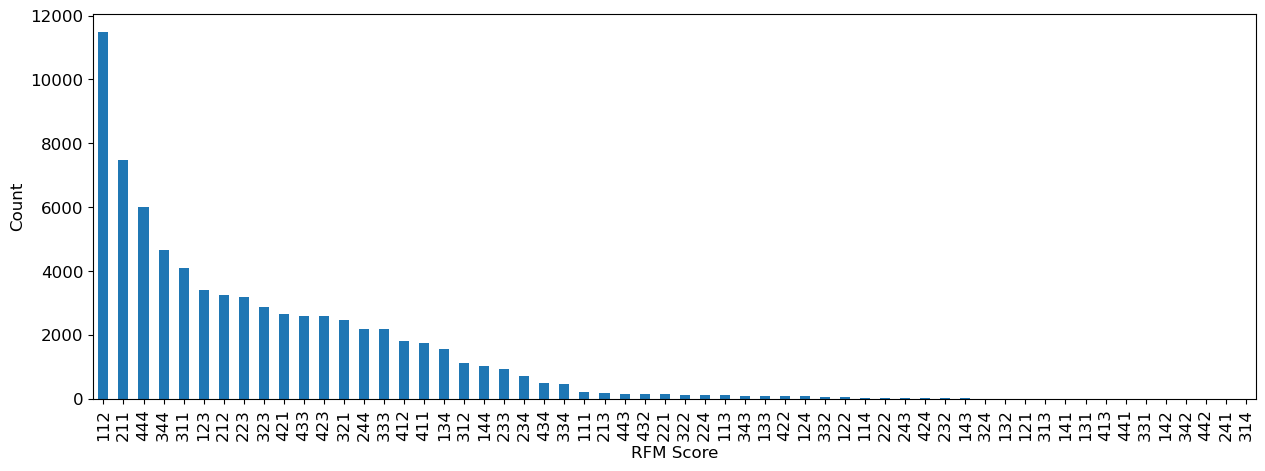

In [24]:
# 可视化
ax = rfm['RFM_Score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [25]:
# 接下来尝试 四分位断点计算RFM 
r_quarters = rfm['Recency'].quantile(q=[0.0, 0.25,0.5,0.75,1]).to_list()
f_quarters = rfm['Frequency'].quantile(q=[0.0, 0.25,0.5,0.75,1]).to_list()
m_quarters = rfm['Monetary'].quantile(q=[0.0, 0.25,0.5,0.75,1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_quarters, f_quarters, m_quarters)),
    columns=['Q_Recency', 'Q_frequency', 'Q_Monetary'],
    index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

,Q_Recency,Q_frequency,Q_Monetary
min,1.0,1.0,0.01
first_part,202.0,1.0,198.00
second_part,497.0,2.0,301.00
third_part,863.0,3.0,699.00
max,2663.0,14.0,3499.00


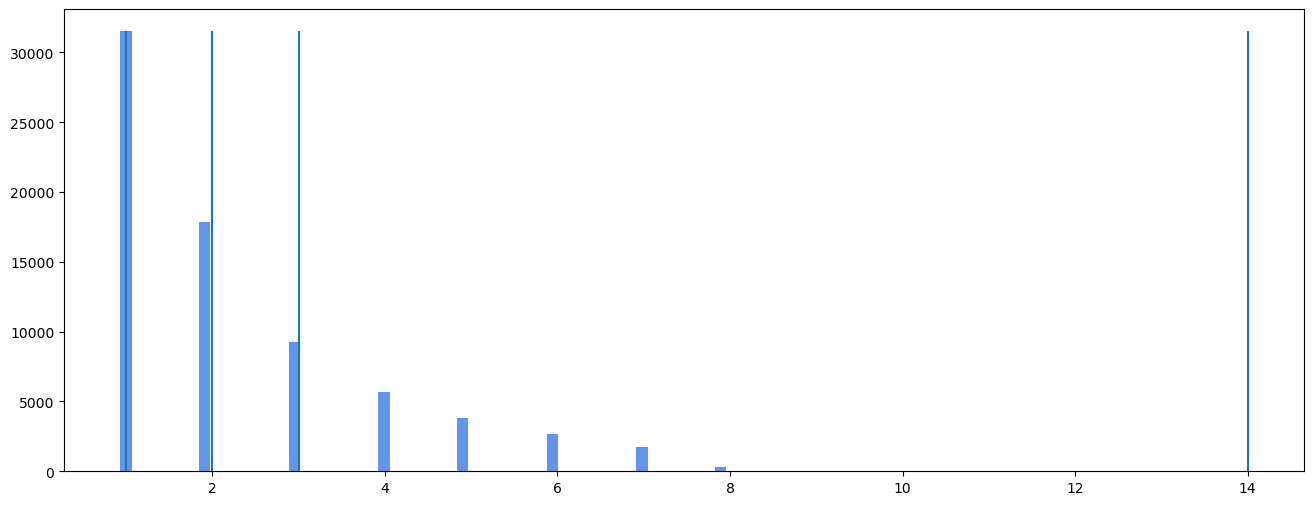

In [27]:
# 可视化Frequency结果
plt.figure(figsize = (16,6))
hist = plt.hist(rfm['Frequency'], bins=100,align='left', color='cornflowerblue')
for q in f_quarters:
    plt.vlines(q, ymin=0, ymax = max(hist[0]))

In [28]:
# 尝试自然分割法进行分组

r_breaks = jenkspy.jenks_breaks(rfm['Recency'], n_classes=4)
f_breaks = jenkspy.jenks_breaks(rfm['Frequency'], n_classes=4)
m_breaks = jenkspy.jenks_breaks(rfm['Monetary'], n_classes=4)
jenks_spread = pd.DataFrame(list(zip(r_breaks, f_breaks, m_breaks)), 
                      columns=['J_Recency','J_Frequency', 'J_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
jenks_spread


,J_Recency,J_Frequency,J_Monetary
min,1,1,0.01
first_part,397,1,427.88
second_part,985,3,841.60
third_part,1729,5,1373.20
max,2663,14,3499.00


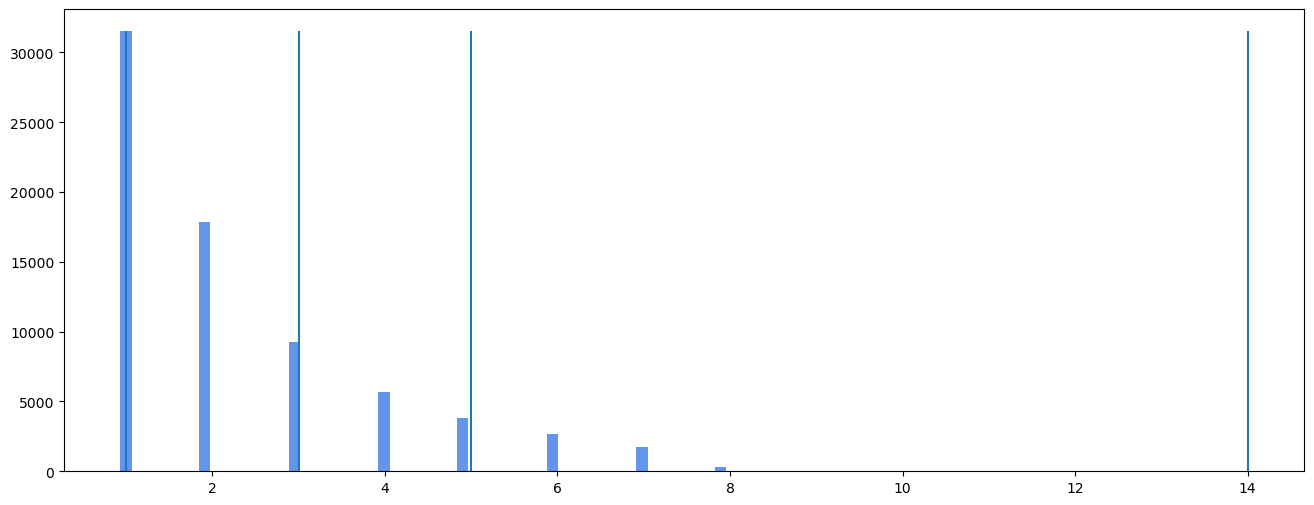

In [29]:
# 可视化 Frequency
plt.figure(figsize = (16,6))
hist = plt.hist(rfm['Frequency'], bins=100,align='left', color='cornflowerblue')
for b in f_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

In [30]:
# 比较断点

df = pd.concat([quartile_spread, jenks_spread], axis=1)
cols = ['Q_Recency', 'Q_frequency', 'Q_Monetary', 'J_Recency', 'J_Frequency', 'J_Monetary']
df[cols]


,Q_Recency,Q_frequency,Q_Monetary,J_Recency,J_Frequency,J_Monetary
min,1.0,1.0,0.01,1,1,0.01
first_part,202.0,1.0,198.00,397,1,427.88
second_part,497.0,2.0,301.00,985,3,841.60
third_part,863.0,3.0,699.00,1729,5,1373.20
max,2663.0,14.0,3499.00,2663,14,3499.00


In [33]:
# 方差拟合函数

# Crediting camdenl with this function
# https://stats.stackexchange.com/users/27263/camdenl?tab=profile

def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, n_classes=classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array.iloc[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

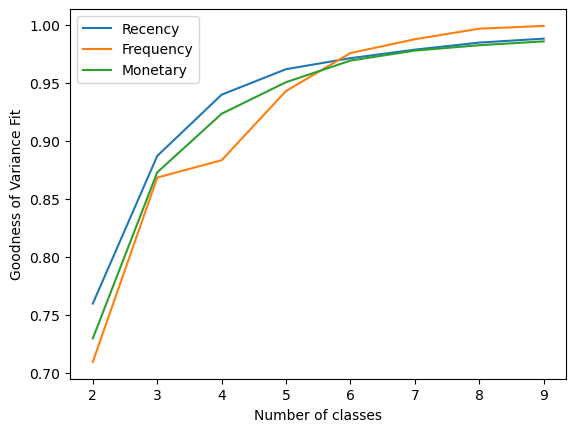

In [34]:
# 确定最佳分段数

my_dict = {}
for col in rfm.columns[:3]:
    results = []
    for i in range(2, 10):
        results.append(goodness_of_variance_fit(rfm[col], i))
    my_dict[col] = results  
plt.plot(range(2, 10), my_dict['Recency'], label='Recency')
plt.plot(range(2, 10), my_dict['Frequency'], label='Frequency')
plt.plot(range(2, 10), my_dict['Monetary'], label='Monetary')
plt.xlabel('Number of classes')
plt.ylabel('Goodness of Variance Fit')
plt.legend(loc='best')
plt.show()

In [41]:
# 根据上图可以看出5是一个相对合适的分段数字

breaks_list = [r_breaks, f_breaks, m_breaks]
f_breaks_unique = sorted(set(f_breaks))
f_labels = list(range(len(f_breaks_unique)-1, 0, -1))

rfm['r_j_score'] = pd.cut(rfm['Recency'], bins=r_breaks, labels=[1, 2, 3, 4], include_lowest=True)
rfm['f_j_score'] = pd.cut(rfm['Frequency'], bins=f_breaks_unique, labels=f_labels, include_lowest=True)
rfm['m_j_score'] = pd.cut(rfm['Monetary'], bins=m_breaks, labels=[4, 3, 2, 1], include_lowest=True)

# Drop columns only if they exist in the DataFrame 首先检查要删除的列是否真的存在于 rfm DataFrame 中 
cols_to_drop = ['r_percentile', 'f_percentile', 'm_percentile']
for col in cols_to_drop:
    if col in rfm.columns:
        rfm.drop(col, axis=1, inplace=True)


rfm.head(5)

,Recency,Frequency,Monetary,r_score,R_Quartile,F_Quartile,M_Quartile,RFM_Score,r_j_score,f_j_score,m_j_score
用户id,,,,,,,,,,,
1,728,1,301.0,3,2,1,2,212,2,3,4
3,1041,2,600.0,4,1,2,3,123,3,3,3
5,2389,1,300.0,4,1,1,2,112,4,3,4
6,111,5,1096.0,1,4,4,4,444,1,2,2
7,1575,1,300.0,4,1,1,2,112,3,3,4


In [42]:
# 合并jenks RFM 分数
rfm['rfm_j_score'] = rfm['r_j_score'].astype(str) + rfm['f_j_score'].astype(str) + rfm['m_j_score'].astype(str)

In [43]:
rfm.head()

,Recency,Frequency,Monetary,r_score,R_Quartile,F_Quartile,M_Quartile,RFM_Score,r_j_score,f_j_score,m_j_score,rfm_j_score
用户id,,,,,,,,,,,,
1,728,1,301.0,3,2,1,2,212,2,3,4,234
3,1041,2,600.0,4,1,2,3,123,3,3,3,333
5,2389,1,300.0,4,1,1,2,112,4,3,4,434
6,111,5,1096.0,1,4,4,4,444,1,2,2,122
7,1575,1,300.0,4,1,1,2,112,3,3,4,334


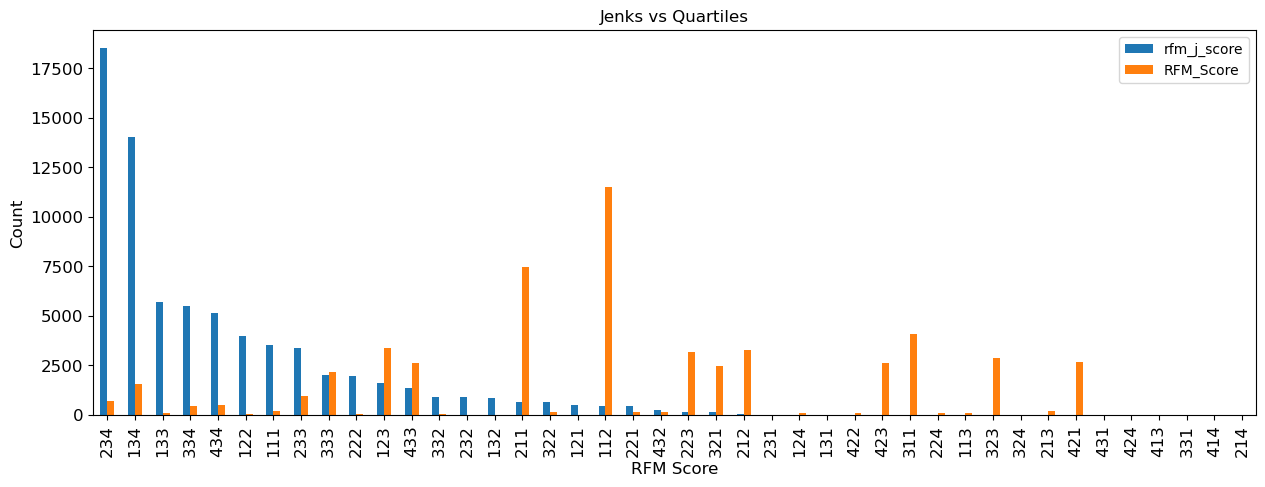

In [45]:
# 对比两种RFM得分（四分位 vs jenks）

df = rfm['rfm_j_score'].value_counts().to_frame().join(rfm['RFM_Score'].value_counts())
ax = df.plot(kind='bar', title ="Jenks vs Quartiles", figsize=(15, 5), legend=True, fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [48]:
# 引入类，接下来使用HDBSCAN进行聚类分析

import hdbscan
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [49]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=12, metric='euclidean', cluster_selection_epsilon=0.5)
clusterer.fit(rfm_scaled)
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

# 查看结果
print(rfm['Cluster'].value_counts())

 7    31313
 6    17826
 5     9219
 4     5623
 3     3780
 1     2623
 2     1694
-1      377
 0      321
Name: Cluster, dtype: int64


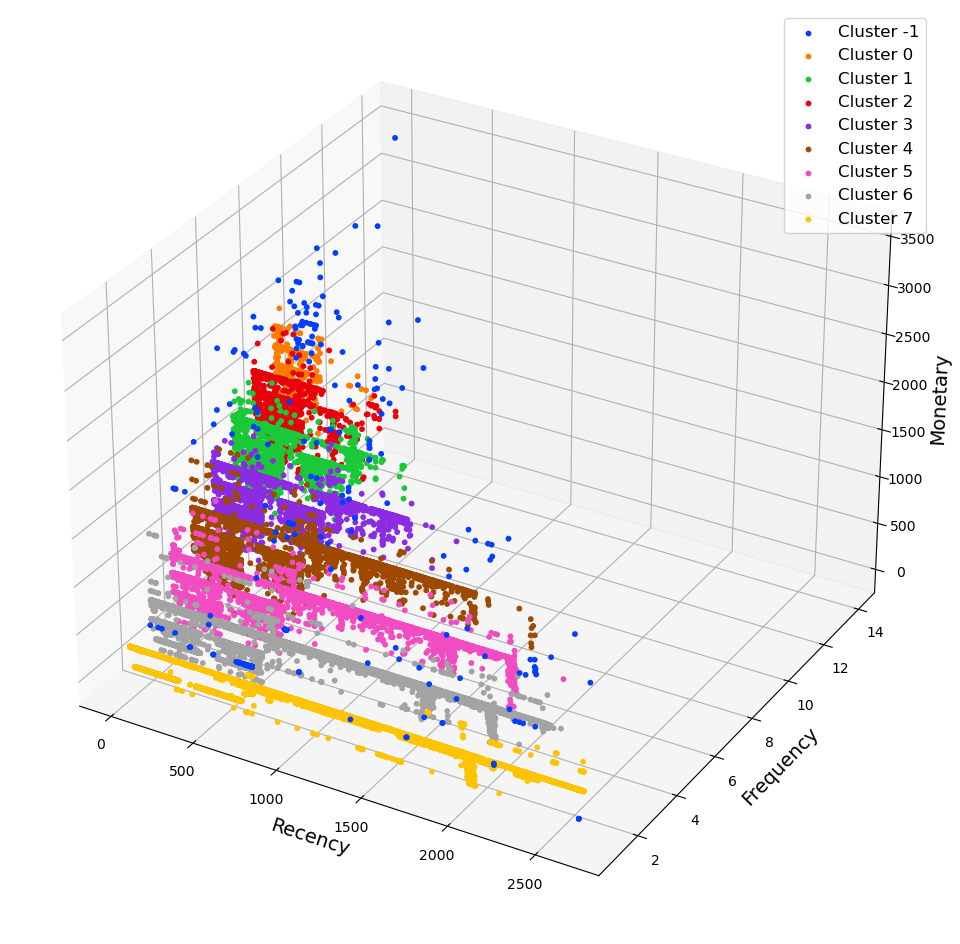

In [50]:
# 可视化
# 获取一个亮色的调色板
bright_colors = sns.color_palette("bright", len(rfm['Cluster'].unique()))

fig = plt.figure(figsize=(18, 12))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(rfm['Cluster'].unique())):
    dx.scatter(rfm[rfm.Cluster == label].Recency,
               rfm[rfm.Cluster == label].Frequency,
               rfm[rfm.Cluster == label].Monetary,
               c=[bright_colors[i]],
               label='Cluster ' + str(label),
               s=10, alpha=1.0)

dx.set_xlabel('Recency', fontsize=14)
dx.set_ylabel('Frequency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)
plt.show()

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Data preprocessing
rfm_values = rfm[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled_values = scaler.transform(rfm_values)

# Step 2: Run K-means clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_values)

# Step 3: Evaluate the clusters
silhouette_avg = silhouette_score(rfm_scaled_values, rfm['KMeans_Cluster'])

# Cluster counts and silhouette score
cluster_counts = rfm['KMeans_Cluster'].value_counts()
cluster_counts, silhouette_avg


(1    22429
 4    20935
 2    12954
 0    10875
 3     5583
 Name: KMeans_Cluster, dtype: int64,
 0.4206047475402126)

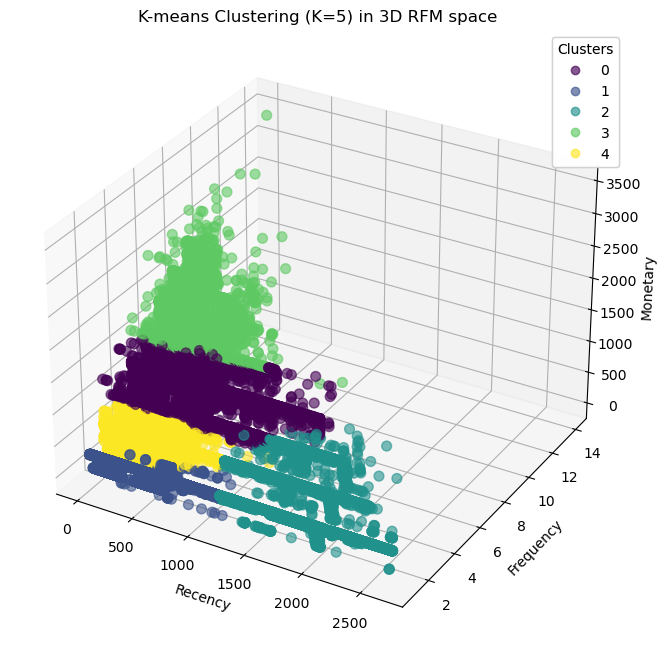

In [52]:
# 对结果进行3D可视化处理

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(rfm['Recency'], 
                     rfm['Frequency'], 
                     rfm['Monetary'], 
                     c=rfm['KMeans_Cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=50)

# Title and labels
ax.set_title("K-means Clustering (K=5) in 3D RFM space")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


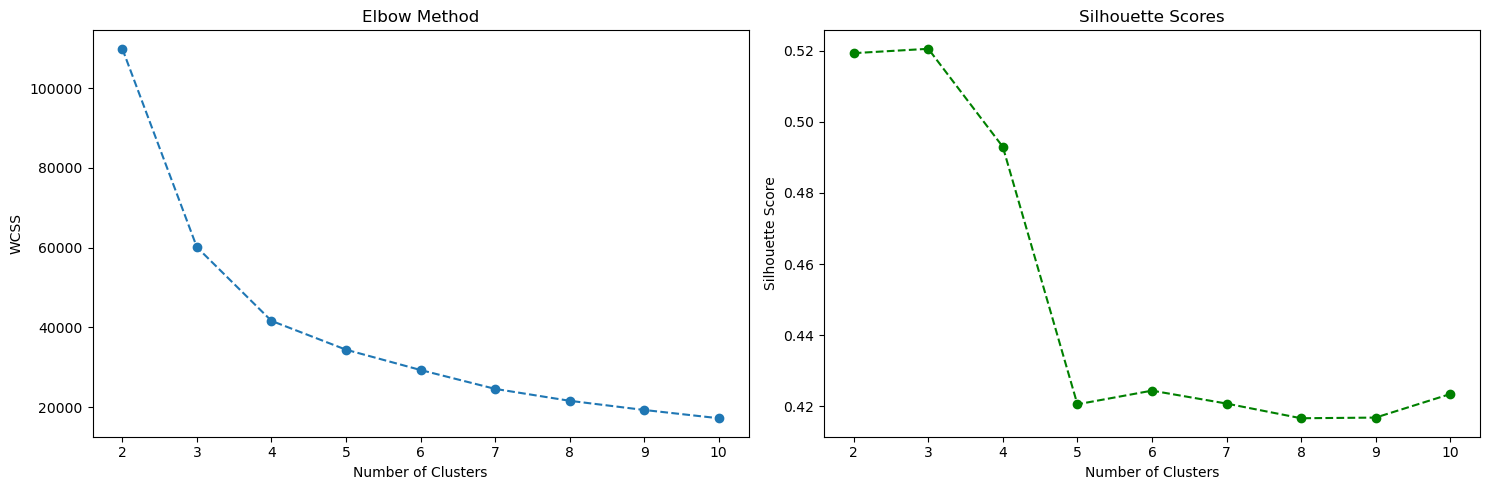

In [54]:
# 计算最佳K值
from sklearn.cluster import KMeans

# Re-running the code to determine optimal k value

wcss = []
silhouette_scores = []
k_values = range(2, 11)  # We will check k values from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_values)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled_values, kmeans.labels_))

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Elbow method
ax[0].plot(k_values, wcss, marker='o', linestyle='--')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WCSS')

# Silhouette scores
ax[1].plot(k_values, silhouette_scores, marker='o', linestyle='--', color='green')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [55]:
# 确定最佳k值为3的结果

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Data preprocessing
rfm_values = rfm[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled_values = scaler.transform(rfm_values)

# Step 2: Run K-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_values)

# Step 3: Evaluate the clusters
silhouette_avg = silhouette_score(rfm_scaled_values, rfm['KMeans_Cluster'])

# Cluster counts and silhouette score
cluster_counts = rfm['KMeans_Cluster'].value_counts()
cluster_counts, silhouette_avg

(1    43149
 0    15773
 2    13854
 Name: KMeans_Cluster, dtype: int64,
 0.5205025102687724)

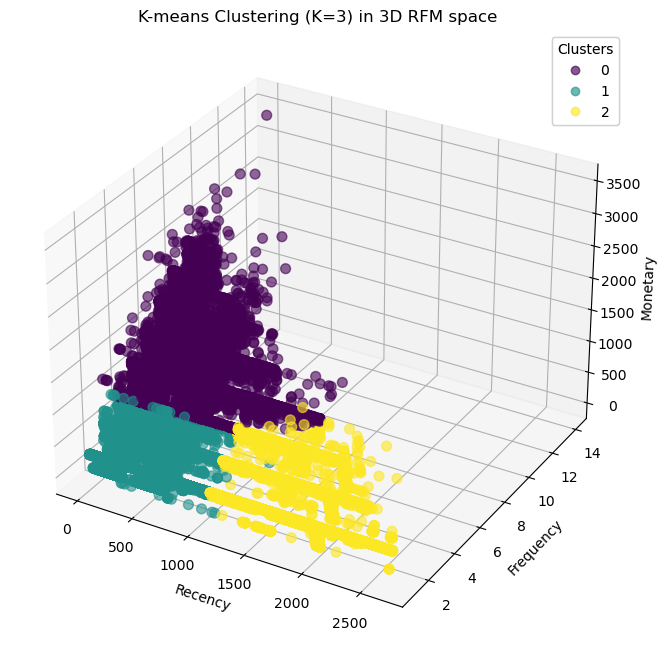

In [57]:
# 对结果进行3D可视化处理

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(rfm['Recency'], 
                     rfm['Frequency'], 
                     rfm['Monetary'], 
                     c=rfm['KMeans_Cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=50)

# Title and labels
ax.set_title("K-means Clustering (K=3) in 3D RFM space")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


In [58]:
# 确定最佳k值为4的结果

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Data preprocessing
rfm_values = rfm[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled_values = scaler.transform(rfm_values)

# Step 2: Run K-means clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_values)

# Step 3: Evaluate the clusters
silhouette_avg = silhouette_score(rfm_scaled_values, rfm['KMeans_Cluster'])

# Cluster counts and silhouette score
cluster_counts = rfm['KMeans_Cluster'].value_counts()
cluster_counts, silhouette_avg

(0    37021
 3    15212
 1    13313
 2     7230
 Name: KMeans_Cluster, dtype: int64,
 0.4929507726526867)

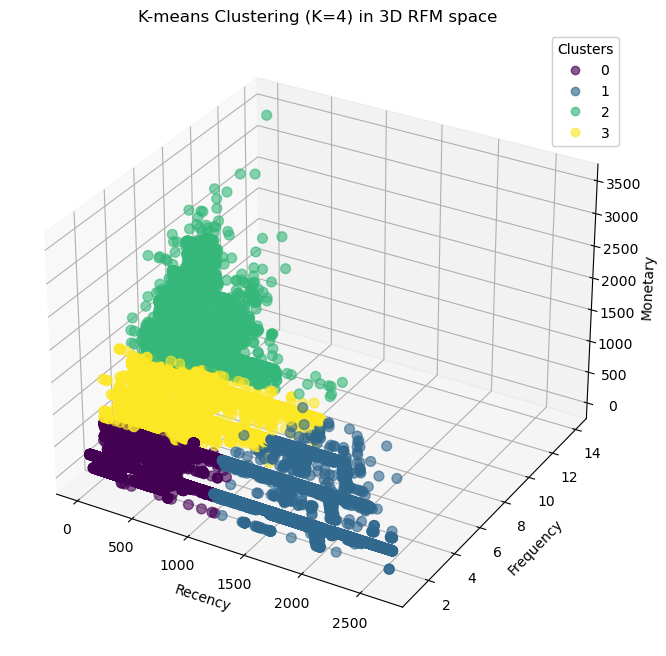

In [60]:
# 对结果进行3D可视化处理

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(rfm['Recency'], 
                     rfm['Frequency'], 
                     rfm['Monetary'], 
                     c=rfm['KMeans_Cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=50)

# Title and labels
ax.set_title("K-means Clustering (K=4) in 3D RFM space")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()
